In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio

In [2]:
# Load data
data = spio.loadmat('1D_poly.mat', squeeze_me=True)
x_train = np.array(data['x_train'])
y_train = np.array(data['y_train']).T

## (b)

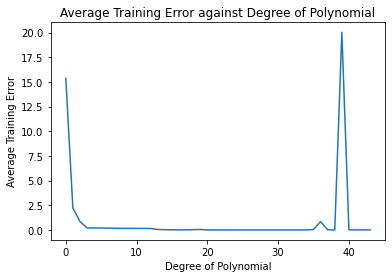

In [3]:
# Max degree
maxDegree = 45

# Training error R(D)
RD = np.zeros(maxDegree-1)

# Training
for degree in range(maxDegree-1):
    j = degree+1
    for i in range(j+1):
        if i == 0:
            Xf = np.array([1]*x_train.size)
        else:
            Xf = np.vstack([np.power(x_train,i), Xf])
    Xf = Xf.T

    # Make prediction
    y_pred = Xf @ np.linalg.solve(Xf.T @ Xf, Xf.T @ y_train)
    RD[degree] = (np.linalg.norm(y_train-y_pred)**2) / maxDegree

plt.plot(RD)
plt.xlabel('Degree of Polynomial')
plt.ylabel('Average Training Error')
plt.title('Average Training Error against Degree of Polynomial')
plt.show()

## (c)

As the degree of polynomial increases, the training error decreases. However, if the degree is very large, the training error increases because of overfitting.

If we try to fit a polynomial of degree n, we get a non-invertible data matrix, so we just cannot use a standard matrix inversion method for a polynomial of degree n.

## (d)

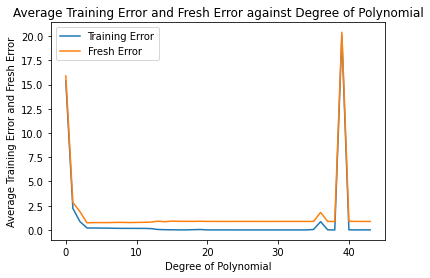

In [4]:
y_fresh = np.array(data['y_fresh']).T

# Max degree
maxDegree = 45

# Training error R(D)
RD = np.zeros(maxDegree-1)
RD_fresh = np.zeros(maxDegree-1)

# Training
for degree in range(maxDegree-1):
    j = degree+1
    for i in range(j+1):
        if i == 0:
            Xf = np.array([1]*x_train.size)
        else:
            Xf = np.vstack([np.power(x_train,i), Xf])
    Xf = Xf.T

    # Make prediction
    y_pred = Xf @ np.linalg.solve(Xf.T @ Xf, Xf.T @ y_train)
    RD[degree] = (np.linalg.norm(y_train-y_pred)**2) / maxDegree
    RD_fresh[degree] = (np.linalg.norm(y_fresh-y_pred)**2) / maxDegree

plt.plot(RD, label='Training Error')
plt.plot(RD_fresh, label='Fresh Error')
plt.legend()
plt.xlabel('Degree of Polynomial')
plt.ylabel('Average Training Error and Fresh Error')
plt.title('Average Training Error and Fresh Error against Degree of Polynomial')
plt.show()

## (e)

In [5]:
RD_fresh.argmin()

3

The right polynomial model minimizes the fresh error, from the plot we know that the polynomial is 3.

## (f) 

In [6]:
# From hw1_prob5.py

def assemble_feature(x, D):
    '''
    x should be an Nx5 dimensional numpy array, where N is the number of data points
    D is the maximum degree of the multivariate polynomial
    '''
    n_feature = x.shape[1]
    Q = [(np.ones(x.shape[0]), 0, 0)]
    i = 0
    
    while Q[i][1] < D:
        cx, degree, last_index = Q[i]
        for j in range(last_index, n_feature):
            Q.append((cx * x[:, j], degree + 1, j))
        i += 1
        
    return np.column_stack([q[0] for q in Q])

In [7]:
data = spio.loadmat('polynomial_regression_samples.mat', squeeze_me=True)
data_x = data['x']
data_y = data['y']
Kc = 4 # 4-fold cross validation
KD = 5 # max D = 5
LAMBDA = [0.05, 0.1, 0.15, 0.2]
feat_x = 0

def lstsq(A, b, lambda_=0):
    
    return np.linalg.solve(A.T @ A + lambda_ * np.eye(A.shape[1]), A.T @ b)

def assemble_feature(x, D):
    n_feature = x.shape[1]
    Q = [(np.ones(x.shape[0]), 0, 0)]
    i = 0
    
    while Q[i][1] < D:
        cx, degree, last_index = Q[i]
        for j in range(last_index, n_feature):
            Q.append((cx * x[:, j], degree + 1, j))
        i += 1
    
    return np.column_stack([q[0] for q in Q])

def fit(D, lambda_):
    Ns = int(data_x.shape[0] * (Kc - 1) / Kc) # training
    Nv = int(Ns / (Kc - 1)) # validation
    Etrain = np.zeros(4)
    Evalid = np.zeros(4)
    
    for c in range(4):
        valid_x = feat_x[c * Nv:(c + 1) * Nv]
        valid_y = data_y[c * Nv:(c + 1) * Nv]
        train_x = np.delete(feat_x, list(range(c * Nv, (c + 1) * Nv)), axis=0)
        train_y = np.delete(data_y, list(range(c * Nv, (c + 1) * Nv)))
        
        w = lstsq(train_x, train_y, lambda_=lambda_)
        Etrain[c] = np.mean((train_y - train_x @ w)**2)
        Evalid[c] = np.mean((valid_y - valid_x @ w)**2)
        
    return np.mean(Etrain), np.mean(Evalid)

In [8]:
def main():
    np.set_printoptions(precision=11)
    Etrain = np.zeros((KD, len(LAMBDA)))
    Evalid = np.zeros((KD, len(LAMBDA)))
    
    for D in range(KD):
        global feat_x
        feat_x = assemble_feature(data_x, D + 1)
        print(feat_x.shape)
        for i in range(len(LAMBDA)):
            Etrain[D, i], Evalid[D, i] = fit(D + 1, LAMBDA[i])
            
    print('Average train error:', Etrain, sep='\n')
    print('Average valid error:', Evalid, sep='\n')

    D, i = np.unravel_index(Evalid.argmin(), Evalid.shape)
    print("D =", D + 1)
    print("lambda =", LAMBDA[i])
        
if __name__ == "__main__":
    main()

(100000, 6)
(100000, 21)
(100000, 56)
(100000, 126)
(100000, 252)
Average train error:
[[0.05856762066 0.05856762225 0.05856762491 0.05856762862]
 [0.05848948229 0.0584902034  0.05849122    0.05849243261]
 [0.05848702853 0.05848893458 0.05849036454 0.05849178744]
 [0.05848700898 0.05848892445 0.05849035741 0.05849178171]
 [0.05848700861 0.05848892426 0.05849035728 0.05849178161]]
Average valid error:
[[0.05857468536 0.0585746856  0.05857468691 0.05857468927]
 [0.05852112813 0.05852038752 0.05852010745 0.05852016181]
 [0.0585210268  0.05852032221 0.05852006042 0.0585201252 ]
 [0.05852102354 0.05852032035 0.05852005896 0.05852012386]
 [0.05852102357 0.05852032036 0.05852005896 0.05852012386]]
D = 4
lambda = 0.15
